# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://www.travelinusa.us/wp-content/uploads/sites/3/2017/11/Painted-Ladies-San-Francisco-01.jpg).

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture on K-means or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment.

In [40]:
# You might want to use the following package
import pandas as pd
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.model_selection import train_test_split 

In [3]:
data_path = "./housing.csv"
data = pd.read_csv(data_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<Axes: >

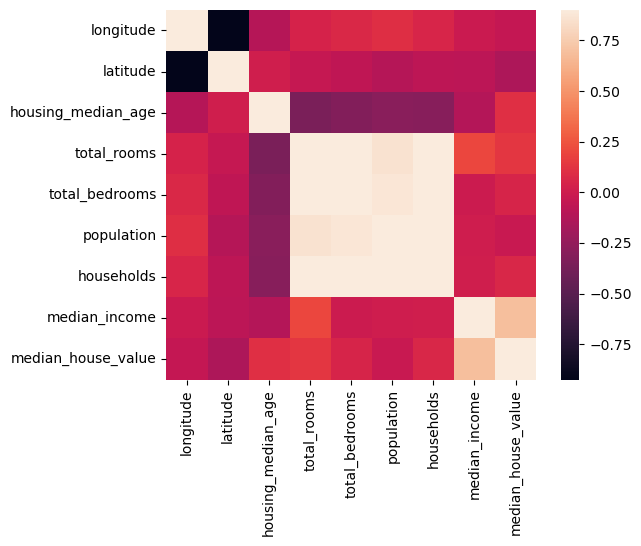

In [6]:
cormat = data.corr()
sns.heatmap(cormat, vmax=.9, square=True)

There are a couple features that have a strong linear correlation. We should keep this in mind as we are looking at the interpretation of our results. There may potentially be a skewing of the clustering towards these four features.

This is because we are scaling each of the features to have mean 0 and standard deviation 1, so clustering may be more biased towards these features that seem to be correlated.

We can consider making a meta feature on these features that are correlated as an extention of this assignment to address this issue.

In [7]:
categorical_variables = data.select_dtypes(include=['object']).columns.tolist()
quant_variables = data.select_dtypes(include='number').columns.to_list()

In [70]:
encodeCat = Pipeline([('impute', SimpleImputer(strategy='most_frequent')),('cat_label',OneHotEncoder(sparse_output=False))])
transformQuant = Pipeline([('impute', SimpleImputer(strategy='mean')), ('standard_scale', StandardScaler())])
feature_preprocess = ColumnTransformer(transformers = [
    ('categorical', encodeCat, categorical_variables), #
    ('quantitative', transformQuant, quant_variables)]
)
feature_preprocess.set_output(transform='pandas')
processed_data = feature_preprocess.fit_transform(data)

Here I contemplated splitting the data into a train and test set before processing the pipline on the train set and transforming the test set using the results. However, I decided just to process on the data as a whole. This is due to a couple reasons.

1. Our goal is not to predict new data points outside of the dataset.

2. Our goal is to use our data to deepen our understanding/interpretation of the clustering. From this perspective, having a test and training set didn't make sense to me.

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [71]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).


#k is the number of clusers, p is the distance metric number, data is the data that needs to be classified
def k_mean(k, p, data):
    max_interation = 150
    iteration = 0
    centroids = 2*np.random.rand(k, len(data[0]))-1
    prev_centroid = None
    sorted_points = [[] for _ in range(k)]
    while np.not_equal(prev_centroid,centroids).any() and iteration < max_interation:
        #assign points to centroid
        sorted_points = [[] for _ in range(k)]
        for point in data:
            distance = np.power(np.sum(np.abs(np.power(point-centroids, p)), axis = 1),1/p)
            centroid_index = np.argmin(distance)
            sorted_points[centroid_index].append(point)
        
        #update centroid
        prev_centroid = centroids
        centroids = [np.mean(cluster, axis = 0) for cluster in sorted_points]
        for i, centroid in enumerate(centroids):
            if np.isnan(centroid).any(): 
                centroids[i] = prev_centroid[i]
        iteration += 1
    return sorted_points, centroids

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [73]:
def inertia_std(sorted_points, centroids):
    sse = 0
    std = []
    for centroid_idx, points in enumerate(sorted_points):
        sumi = 0
        for point in points:
            distance_squared = np.sum(np.power(point-centroids[centroid_idx], 2))
            sse += distance_squared
            sumi += distance_squared
        sumi /= len(points)
        sumi = np.sqrt(sumi)
        std.append(sumi)
    return sse, std

In [76]:
sorted_pointsk2p2, centroidsk2p2 = k_mean(2, 2, processed_data.to_numpy())

In [111]:
#Sum Squared Error and Standard Deviation of my k-means algorithm when k=2, p=2
i2, std2 = inertia_std(sorted_pointsk2p2, centroidsk2p2)
print(i2, std2)

155912.46422768125 [3.8356486229972298, 2.571297827660313]


These numbers don't mean much for now. I will use the elblow approach later to determine the best k.

In [95]:
#returns a dataframe with the proper pentroid assigned to it
def centroid_dataframe(sorted_points):
        new_columns = feature_preprocess.get_feature_names_out().tolist()
        df = pd.DataFrame(columns = new_columns)
        for centroid_idx, points in enumerate(sorted_points):
                temp_df = pd.DataFrame(points, columns=new_columns)
                temp_df['centroid_label'] = centroid_idx
                df = df.append(temp_df)
        return df

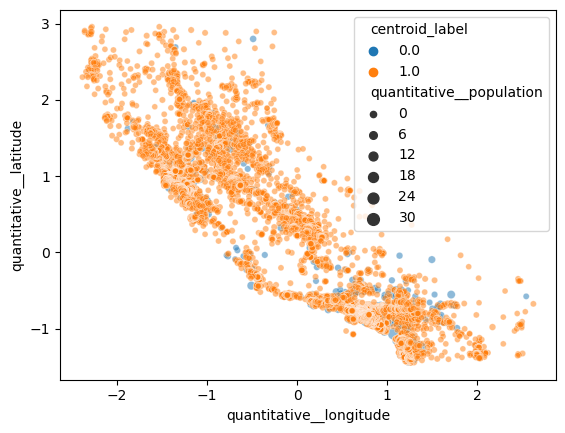

In [107]:
dfk2p2 = centroid_dataframe(sorted_pointsk2p2)
sns.scatterplot(dfk2p2, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.5, size='quantitative__population')

These results don't really split the cities in California into any regions.

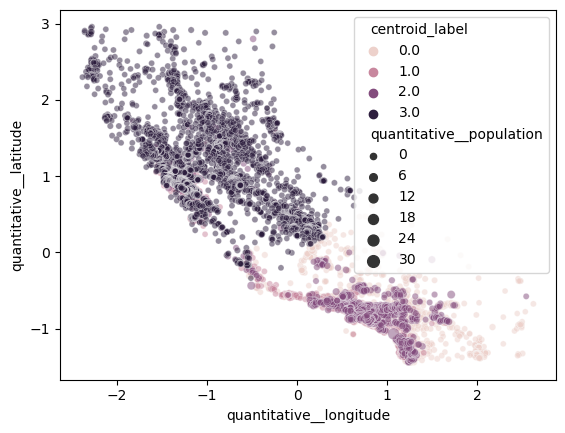

In [108]:
sorted_pointsk4p2, centroidsk4p2 = k_mean(4, 2, processed_data.to_numpy())
dfk4p2 = centroid_dataframe(sorted_pointsk4p2)
sns.scatterplot(dfk4p2, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.5, size='quantitative__population')

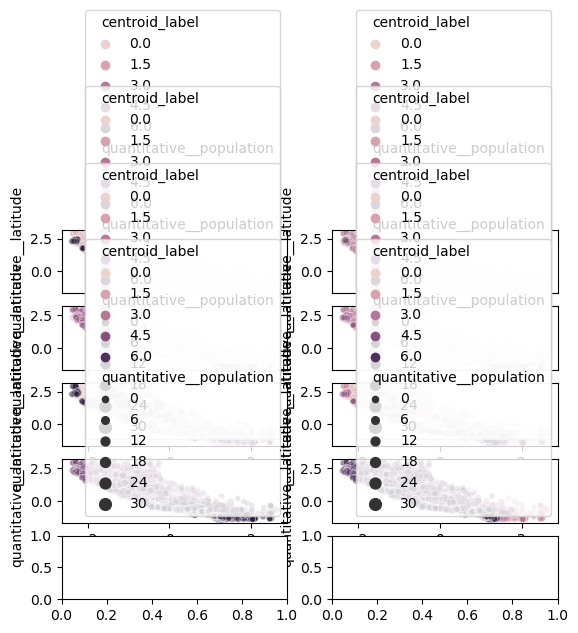

In [116]:
from matplotlib import pyplot as plt
fig,axes = plt.subplots(5,2)
iSTD = []
for i in range(8):
    sorted_pointstemp, centroidstemp = k_mean(8, 2, processed_data.to_numpy())
    dftemp = centroid_dataframe(sorted_pointstemp)
    sns.scatterplot(ax = axes[i // 2, i%2],data = dftemp, x="quantitative__longitude", y = "quantitative__latitude", 
                hue = 'centroid_label', alpha = 0.5, size='quantitative__population')
    i2, std2 = inertia_std(sorted_pointstemp, centroidstemp)
    iSTD.append((id,std2))
    
    


In [109]:
inertia_std(sorted_pointsk4p2, centroidsk4p2)

(107066.88602727005,
 [1.8777830185415272,
  2.5414345508635674,
  4.039156084649933,
  2.0700538662827577])

With k = 4, we see more of a geographical representation

The inertia 

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge.



- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!